In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
filepaths = []
for year in range(13,19):
    filepath = './data/' + str(year) + 'zpallagi.csv'
    filepaths.append(filepath)

In [3]:
tax_data = {}
for i in range(6):
    tax_data[2013+i] = pd.read_csv(filepaths[i])

In [4]:
for i in range(2013,2019,1):
    print(tax_data[i].shape)

(166740, 114)
(166722, 127)
(166698, 131)
(179796, 147)
(166537, 153)
(165935, 153)


In [5]:
def tax_data_clean(df, verbose = True):
    
    #convert all columns to lower cases:
    df.columns = df.columns.str.lower()

    #convert zipcode to str type and fill in leading '0's
    df['zipcode'] = df.zipcode.astype('str')
    df['zipcode'] = df['zipcode'].apply(lambda x: x.zfill(5))
    if verbose:
        print("convert zipcode to str type and fill in leading '0's")
    
    #convert statefips column to categorical variable
    df['statefips'] = df['statefips'].astype('object')
    
    #only keep the columns are common to all 6 years' data
    columns = ['statefips','state','zipcode','agi_stub','n1','mars1','mars2','mars4','prep',
           'n2','numdep','a00100','n02650','a02650','n00200','a00200','n00300','a00300','n00600',
           'a00600','n00650','a00650','n00700','a00700','n00900','a00900','n01000','a01000',
           'n01700','a01700','schf','n02300','a02300','n02500','a02500','n26270','a26270',
           'n02900','a02900','n03220','a03220','n03300','a03300','n03270','a03270','n03150',
           'a03150','n03210','a03210','n04470','a04470','a00101','n18425','a18425','n18450',
           'a18450','n18500','a18500','n18300','a18300','n19300','a19300','n19700','a19700',
           'n04800','a04800','n05800','a05800','n09600','a09600','n07100','a07100','n07300',
           'a07300','n07180','a07180','n07230','a07230','n07240','a07240','n07220','a07220',
           'n07260','a07260','n09400','a09400','n10600','a10600','n59660','a59660','n59720',
            'a59720','n11070','a11070','n10960','a10960','n06500','a06500','n10300','a10300',
            'n85300','a85300','n11901','a11901','n11902','a11902']
    try: 
        df = df[columns]
    except:
        df = df[['statefips','state','zipcode','agi_stub','n1','mars1','mars2','mars4','prep',
           'n2','numdep','a00100','n02650','a02650','n00200','a00200','n00300','a00300','n00600',
           'a00600','n00650','a00650','n00700','a00700','n00900','a00900','n01000','a01000',
           'n01750','a01750','schf','n02300','a02300','n02500','a02500','n26270','a26270',
           'n02900','a02900','n03220','a03220','n03300','a03300','n03270','a03270','n03150',
            'a03150','n03210','a03210','n04470','a04470','a00101','n18425','a18425','n18450',
            'a18450','n18500','a18500','n18300','a18300','n19300','a19300','n19700','a19700',
            'n04800','a04800','n05800','a05800','n09600','a09600','n07100','a07100','n07300',
            'a07300','n07180','a07180','n07230','a07230','n07240','a07240','n07225','a07225',
            'n07260','a07260','n09400','a09400','n10600','a10600','n59660','a59660','n59720',
            'a59720','n11070','a11070','n10960','a10960','n06500','a06500','n10300','a10300',
            'n85300','a85300','n11901','a11901','n11902','a11902']]
        df = df.rename(columns={'n01750':'n01700',
                                'a01750':'a01700',
                               'n07225':'n07220',
                               'a07225':'a07220'})
        
    if verbose:
        print("only keep the columns are common to all 6 years' data")
    
    #remove state level obs (00000) and zipcode were categorized as “other” (99999).
    df = df.loc[(df.zipcode != '00000') & (df.zipcode != '99999'),]
    if verbose:
        print("remove state level obs and zipcodes that were categorized as 'other'.")

    return df

In [6]:
def agi_conversion(df, verbose = True):
    
    #retrive # of high income and low income returns
    df_agi = df[['zipcode','agi_stub','n1']].pivot(index='zipcode',columns='agi_stub',values='n1')
    df_agi['high_income'] = df_agi.iloc[:,4] + df_agi.iloc[:,5]
    df_agi['low_income'] = df_agi.iloc[:,0]
    agi = df_agi.reset_index()[['zipcode','high_income','low_income']]
    
    #combine the high income/ low income info back to main dataframe
    df_byzip = df.groupby('zipcode').sum().reset_index()
    df_byzip = df_byzip.merge(agi, on='zipcode',how='inner')
    df_byzip = df_byzip[df_byzip.columns[df_byzip.columns != 'agi_stub']]
    
    #combine the state info back to the dataset
    df_state = df[['state','zipcode']][~df[['state','zipcode']].duplicated()]
    df_byzip = df_byzip.merge(df_state, on='zipcode',how='left')
    
    if verbose:
        print('retrive and combine the high income/ low income info back to main dataframe')

    return df_byzip
    

In [7]:
def normalization(df, verbose = True):
    
    #create lists of columns need to be normalized by # of return or amount of return
    count_col = []
    amount_col = []
    for col in df.columns:
        if col in ['n1','a00100','a02650']:
            pass
        elif col.startswith('n',0,1):
            count_col.append(col)
        elif col.startswith('a',0,1):
            amount_col.append(col)
    count_col = ['mars1','mars2','mars4','prep','schf','high_income','low_income'] + count_col 

    #normalize the number of retruns columns by dividing total number of returns
    for col in count_col:
        df[col] = df[col]/df['n1']
    if verbose:
        print('normalize the number of retruns columns by dividing total number of returns')

    #normalize the retrun amount columns by dividing total return amount
    for col in amount_col:
        df[col] = df[col]/df['a02650']
    if verbose:
        print('normalize the retrun amount columns by dividing total return amount')

    return df

In [8]:
def standardization(df, verbose = True):
    
    #create a column for average income amount for all returns
    df['avg_income'] = df['a02650']/df['n1']
    
    #convert 'n1','a00100','a02650' into standardized features
    for col in ['n1','a00100','a02650','avg_income']:
        df[col] = (df[col] - df[col].mean())/df[col].std()
    if verbose:
        print("convert 'n1','a00100','a02650','avg_income' into standardized features")
        
    return df

In [9]:
tax_model_data = {}

for i in range(2013,2019,1):
    print(f'year {i}')
    df = tax_data_clean(tax_data[i])
    df = agi_conversion(df)
    df = normalization(df)
    df = standardization(df)
    df['year'] = i
    df['year'] = df['year'].astype('object')
    tax_model_data[i] = df

year 2013
convert zipcode to str type and fill in leading '0's
only keep the columns are common to all 6 years' data
remove state level obs and zipcodes that were categorized as 'other'.
retrive and combine the high income/ low income info back to main dataframe
normalize the number of retruns columns by dividing total number of returns
normalize the retrun amount columns by dividing total return amount
convert 'n1','a00100','a02650','avg_income' into standardized features
year 2014
convert zipcode to str type and fill in leading '0's
only keep the columns are common to all 6 years' data
remove state level obs and zipcodes that were categorized as 'other'.
retrive and combine the high income/ low income info back to main dataframe
normalize the number of retruns columns by dividing total number of returns
normalize the retrun amount columns by dividing total return amount
convert 'n1','a00100','a02650','avg_income' into standardized features
year 2015
convert zipcode to str type and fi

In [10]:
for i in range(2013,2019,1):
    print(tax_model_data[i].shape)

(27688, 108)
(27685, 108)
(27681, 108)
(29872, 108)
(27658, 108)
(27556, 108)


In [11]:
tax_analysis_data = {}

for i in range(2013,2019,1):
    print(f'year {i}')
    df = tax_data_clean(tax_data[i])
    df = agi_conversion(df)
    df = normalization(df)
    df['avg_income'] = df['a02650']/df['n1']
    df['year'] = i
    df['year'] = df['year'].astype('object')
    tax_analysis_data[i] = df

year 2013
convert zipcode to str type and fill in leading '0's
only keep the columns are common to all 6 years' data
remove state level obs and zipcodes that were categorized as 'other'.
retrive and combine the high income/ low income info back to main dataframe
normalize the number of retruns columns by dividing total number of returns
normalize the retrun amount columns by dividing total return amount
year 2014
convert zipcode to str type and fill in leading '0's
only keep the columns are common to all 6 years' data
remove state level obs and zipcodes that were categorized as 'other'.
retrive and combine the high income/ low income info back to main dataframe
normalize the number of retruns columns by dividing total number of returns
normalize the retrun amount columns by dividing total return amount
year 2015
convert zipcode to str type and fill in leading '0's
only keep the columns are common to all 6 years' data
remove state level obs and zipcodes that were categorized as 'other'.

In [12]:
for i in range(2013,2019,1):
    print(tax_analysis_data[i].shape)

(27688, 108)
(27685, 108)
(27681, 108)
(29872, 108)
(27658, 108)
(27556, 108)


In [13]:
tax_analysis_data[2013].head()

,zipcode,n1,mars1,mars2,mars4,prep,n2,numdep,a00100,n02650,a02650,n00200,a00200,n00300,a00300,n00600,a00600,n00650,a00650,n00700,a00700,n00900,a00900,n01000,a01000,n01700,a01700,schf,n02300,a02300,n02500,a02500,n26270,a26270,n02900,a02900,n03220,a03220,n03300,a03300,n03270,a03270,n03150,a03150,n03210,a03210,n04470,a04470,a00101,n18425,a18425,n18450,a18450,n18500,a18500,n18300,a18300,n19300,a19300,n19700,a19700,n04800,a04800,n05800,a05800,n09600,a09600,n07100,a07100,n07300,a07300,n07180,a07180,n07230,a07230,n07240,a07240,n07220,a07220,n07260,a07260,n09400,a09400,n10600,a10600,n59660,a59660,n59720,a59720,n11070,a11070,n10960,a10960,n06500,a06500,n10300,a10300,n85300,a85300,n11901,a11901,n11902,a11902,high_income,low_income,state,avg_income,year
0,01001,8780.0,0.541002,0.345103,0.099089,0.566059,1.724374,0.455581,471936.0,1.0,477601.0,0.832574,0.751554,0.384966,0.006790,0.218679,0.010852,0.205011,0.007538,0.243736,0.002642,0.115034,0.027305,0.153759,0.011193,0.238041,0.089769,0.000000,0.085421,0.011516,0.157175,0.033402,0.038724,0.018484,0.248292,0.011859,0.036446,0.000165,0.003417,0.000984,0.020501,0.002182,0.017084,0.001397,0.095672,0.001803,0.363326,0.116522,0.582740,0.335991,0.028237,0.021640,0.000258,0.335991,0.020840,0.363326,0.051043,0.290433,0.034133,0.287016,0.010528,0.817768,0.672078,0.812073,0.109688,0.010251,0.000720,0.300683,0.005825,0.047836,0.000069,0.038724,0.000354,0.075171,0.001621,0.045558,0.000151,0.140091,0.003264,0.030752,0.000134,0.096811,0.004786,0.953303,0.135561,0.113895,0.003989,0.093394,0.003319,0.061503,0.001470,0.064920,0.001114,0.764237,0.103865,0.799544,0.109824,0.005695,0.000165,0.169704,0.009104,0.787016,0.033622,0.142369,0.331435,MA,54.396469,2013
1,01002,9570.0,0.537095,0.368861,0.080460,0.496343,1.733542,0.463950,744429.0,1.0,762298.0,0.801463,0.568528,0.494253,0.011135,0.352142,0.042777,0.329154,0.031602,0.207941,0.002174,0.222571,0.060810,0.309300,0.059815,0.219436,0.104601,0.004180,0.042842,0.003677,0.159875,0.028001,0.073145,0.051930,0.338558,0.023442,0.047022,0.000146,0.024033,0.006467,0.051202,0.004957,0.029258,0.001837,0.098224,0.001210,0.415883,0.142530,0.752525,0.375131,0.039200,0.034483,0.000298,0.384535,0.034294,0.412748,0.075125,0.276907,0.025173,0.356322,0.020489,0.803553,0.712334,0.787879,0.140545,0.060606,0.005107,0.377220,0.004854,0.134796,0.000750,0.047022,0.000273,0.111808,0.001275,0.038662,0.000097,0.101358,0.001493,0.036573,0.000531,0.181818,0.008989,0.941484,0.161226,0.112853,0.002384,0.092999,0.002082,0.059561,0.000918,0.072100,0.000861,0.728318,0.135162,0.769070,0.146751,0.040752,0.001772,0.236155,0.014338,0.685475,0.021026,0.242424,0.370951,MA,79.654963,2013
2,01005,2230.0,0.470852,0.439462,0.085202,0.551570,1.914798,0.556054,127991.0,1.0,129645.0,0.878924,0.761657,0.403587,0.005500,0.188341,0.011686,0.170404,0.006063,0.246637,0.002252,0.147982,0.041537,0.147982,0.010961,0.206278,0.072452,0.008969,0.112108,0.013907,0.130045,0.024906,0.035874,0.006695,0.291480,0.012735,0.053812,0.000247,0.000000,0.000000,0.017937,0.002291,0.013453,0.001365,0.107623,0.001890,0.381166,0.124679,0.609696,0.345291,0.028856,0.017937,0.000216,0.358744,0.022693,0.376682,0.053677,0.322870,0.042030,0.286996,0.008739,0.843049,0.657935,0.838565,0.103236,0.008969,0.000802,0.327354,0.007096,0.035874,0.000046,0.035874,0.000393,0.076233,0.001597,0.044843,0.000116,0.165919,0.004065,0.040359,0.000239,0.125561,0.006317,0.964126,0.125095,0.103139,0.003378,0.089686,0.002854,0.058296,0.001280,0.062780,0.001049,0.793722,0.096093,0.820628,0.103891,0.000000,0.000000,0.192825,0.012434,0.775785,0.032304,0.156951,0.309417,MA,58.136771,2013
3,01007,7300.0,0.458904,0.449315,0.078082,0.521918,1.926027,0.576712,481692.0,1.0,489020.0,0.867123,0.769952,0.497260,0.005513,0.228767,0.009427,0.212329,0.006497,0.293151,0.002509,0.157534,0.034156,0.172603,0.020778,0.210959,0.076015,0.006849,0.073973,0.008049,0.116438,0.019609,0.050685,0.030093,0.304110,0.014991,0.053425,0.000200,0.008219,0.002182,0.031507,0.003114,0.026027,0.0

## For data analysis, we select a few features to focus on.

There are many taxable income subcategories, to limit the resources on important feature, we will only look at the subcategories appear in more than 20% of all tax return files. In the meantime, we will also include columns that could be a defining feature of local population, such as porportion of high income house hold. We will exclude columns don't provide much unique information. 

In [14]:
sample = tax_analysis_data[2013]

In [15]:
sample.mean()[sample.mean() > 0.2]

zipcode                inf
n1            5.088424e+03
mars1         4.341926e-01
mars2         4.198217e-01
prep          5.865746e-01
n2            1.996783e+00
numdep        6.429889e-01
a00100        3.235319e+05
n02650        9.999929e-01
a02650        3.282850e+05
n00200        8.226648e-01
a00200        6.902759e-01
n00300        3.132181e-01
n01700        2.034395e-01
n02900        2.523431e-01
n04470        2.549831e-01
a00101        4.546040e-01
n18500        2.159523e-01
n18300        2.530798e-01
n04800        7.556634e-01
a04800        6.228637e-01
n05800        7.478477e-01
n07100        3.024971e-01
n10600        9.401103e-01
n06500        6.718018e-01
n10300        7.342886e-01
n11902        7.617665e-01
low_income    3.955789e-01
avg_income    5.822301e+01
year          2.013000e+03
dtype: float64

In [18]:
important_features = ['zipcode','n1','mars1','mars2','numdep',\
                     'a02650','n00200','n00300','n01700',\
                     'a04800','high_income','low_income','state','avg_income','year']

In [19]:
full_analysis = tax_analysis_data[2013][important_features]
for i in range(2014,2019,1):
    full_analysis = pd.concat([full_analysis,tax_analysis_data[i][important_features]])

In [20]:
full_analysis.columns = ['zipcode','num_return','num_single','num_joint','num_dependent',\
                     'income_amt','num_salary','num_w_interests','num_pensions',\
                     'taxable_income_amt','high_income','low_income','state','avg_income','year']

In [69]:
features = ['num_return', 'num_single', 'num_joint', 'num_dependent',
       'income_amt', 'num_salary', 'num_w_interests', 'num_pensions',
       'taxable_income_amt', 'high_income', 'low_income','avg_income']

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


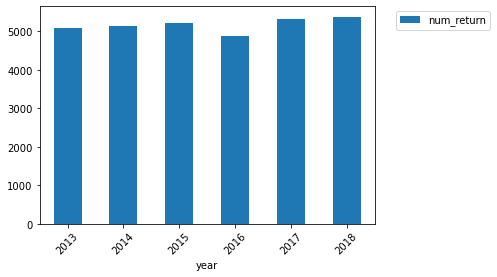

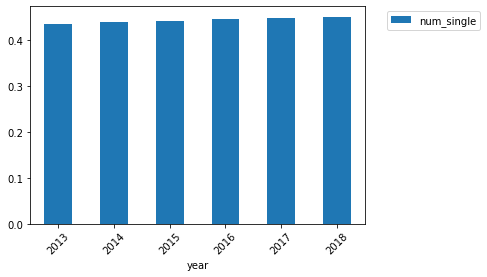

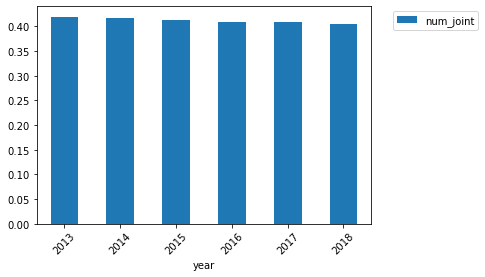

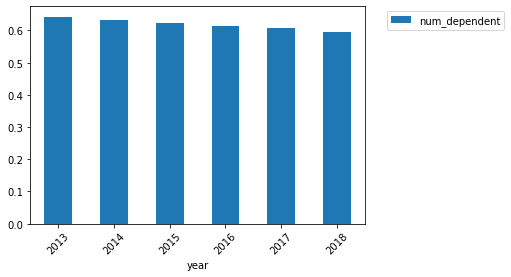

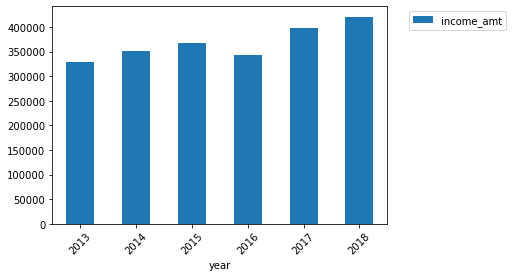

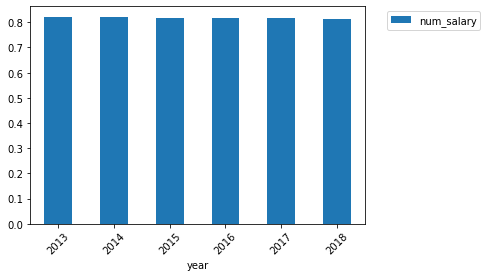

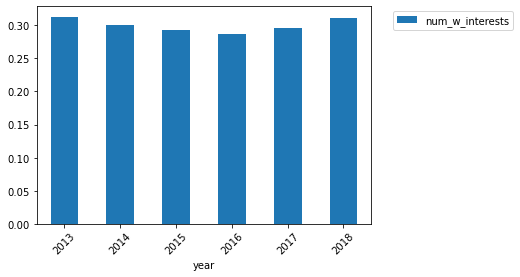

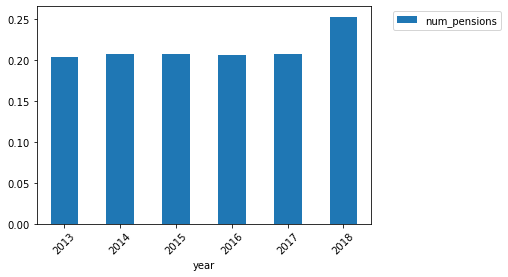

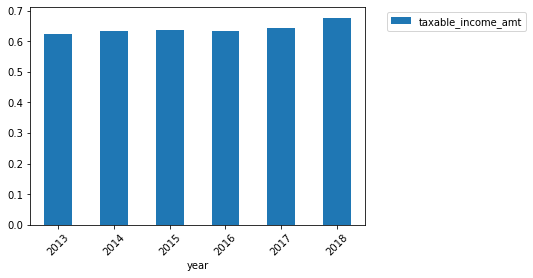

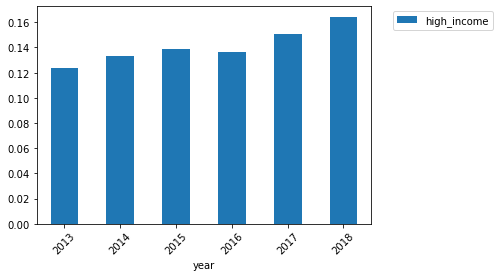

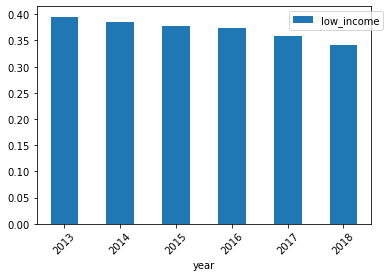

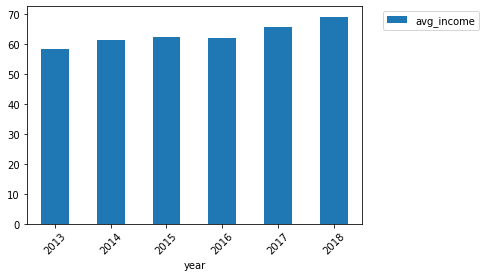

In [87]:
for col in features:
    print(full_analysis.groupby('year')[[col]].mean().reset_index().plot.bar(x='year', y=col, rot=45))
    plt.legend(bbox_to_anchor=(1.05, 1))

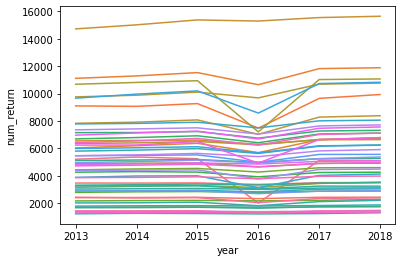

In [48]:
table = full_analysis.groupby(['year','state']).mean()['num_return'].reset_index()
sns.lineplot(data=table, x="year", y="num_return", hue="state",legend=False)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

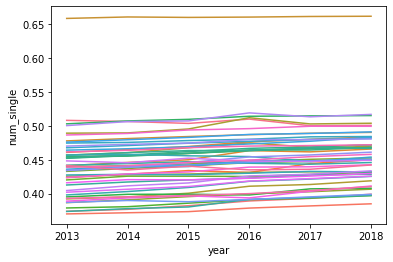

In [36]:
table = full_analysis.groupby(['year','state']).mean()['num_single'].reset_index()
sns.lineplot(data=table, x="year", y="num_single", hue="state", legend=False)

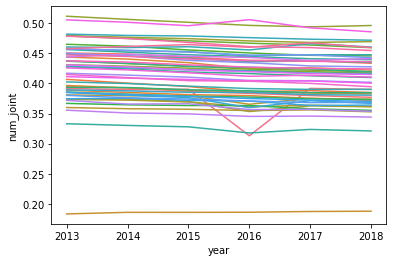

In [37]:
table = full_analysis.groupby(['year','state']).mean()['num_joint'].reset_index()
sns.lineplot(data=table, x="year", y='num_joint', hue="state", legend=False)

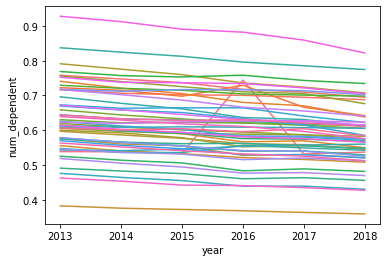

In [38]:
table = full_analysis.groupby(['year','state']).mean()['num_dependent'].reset_index()
sns.lineplot(data=table, x="year", y='num_dependent', hue="state", legend=False)

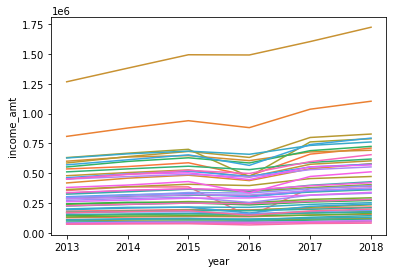

In [39]:
table = full_analysis.groupby(['year','state']).mean()['income_amt'].reset_index()
sns.lineplot(data=table, x="year", y='income_amt', hue="state", legend=False)

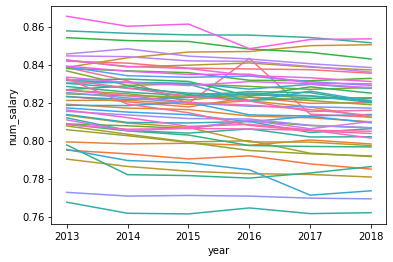

In [40]:
table = full_analysis.groupby(['year','state']).mean()['num_salary'].reset_index()
sns.lineplot(data=table, x="year", y='num_salary', hue="state", legend=False)

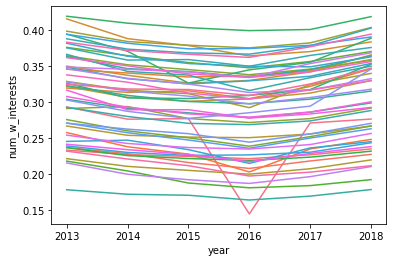

In [41]:
table = full_analysis.groupby(['year','state']).mean()['num_w_interests'].reset_index()
sns.lineplot(data=table, x="year", y='num_w_interests', hue="state", legend=False)

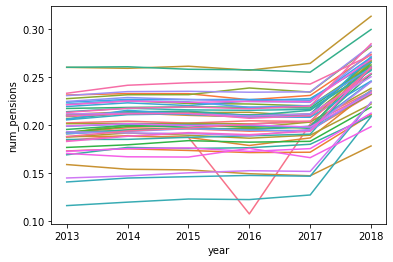

In [42]:
table = full_analysis.groupby(['year','state']).mean()['num_pensions'].reset_index()
sns.lineplot(data=table, x="year", y='num_pensions', hue="state", legend=False)

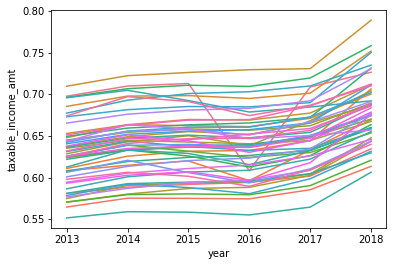

In [43]:
table = full_analysis.groupby(['year','state']).mean()['taxable_income_amt'].reset_index()
sns.lineplot(data=table, x="year", y='taxable_income_amt', hue="state", legend=False)

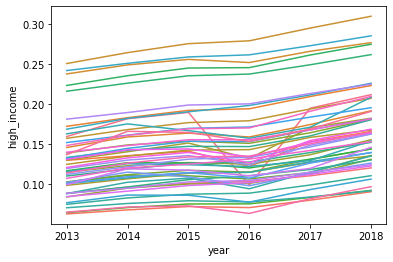

In [44]:
table = full_analysis.groupby(['year','state']).mean()['high_income'].reset_index()
sns.lineplot(data=table, x="year", y='high_income', hue="state", legend=False)

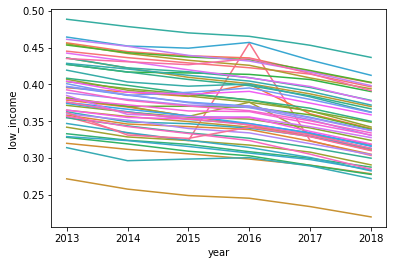

In [45]:
table = full_analysis.groupby(['year','state']).mean()['low_income'].reset_index()
sns.lineplot(data=table, x="year", y='low_income', hue="state", legend=False)

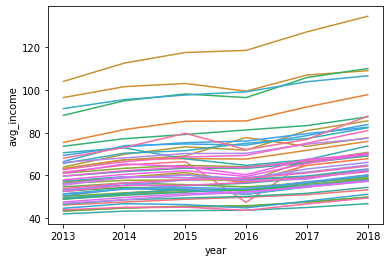

In [46]:
table = full_analysis.groupby(['year','state']).mean()['avg_income'].reset_index()
sns.lineplot(data=table, x="year", y='avg_income', hue="state", legend=False)

In [64]:
delta16 = full_analysis.groupby(['year','state']).mean()['num_pensions'].unstack('year').reset_index().set_index('state')
delta16['delta'] = delta16.iloc[:,3] - delta16.iloc[:,4]
delta16['delta'].sort_values().head(1)

state
AK   -0.093597
Name: delta, dtype: float64

It seems during 2016 tax reformation, the tax return filed in Alaska showed abnormal pattern in many aspects.

In [77]:
for i in range(2013,2019,1):
    print(f'year {i}')
    print('\n')
    df = full_analysis.loc[full_analysis['year']==i,]
    for col in features:
        print(col)
        print(df[col].mean())
        print('\n')
        print(df.set_index('zipcode')[col].sort_values(ascending = False).head(3))
        print(df.set_index('zipcode')[col].sort_values(ascending = True).head(3))
        print('\n')
        print('\n')

year 2013


num_return
5088.423504767408


zipcode
11220    51970.0
11226    50400.0
11373    49090.0
Name: num_return, dtype: float64
zipcode
76436    90.0
80812    90.0
83287    90.0
Name: num_return, dtype: float64




num_single
0.43419258476379


zipcode
78843    1.000000
53706    1.000000
58705    0.958904
Name: num_single, dtype: float64
zipcode
40982    0.000000
85708    0.095652
58204    0.109091
Name: num_single, dtype: float64




num_joint
0.4198217051988958


zipcode
85708    0.826087
32227    0.806452
58204    0.800000
Name: num_joint, dtype: float64
zipcode
55455    0.0
64147    0.0
47406    0.0
Name: num_joint, dtype: float64




num_dependent
0.6429888594799833


zipcode
12733    2.625000
93249    2.318966
72679    2.238095
Name: num_dependent, dtype: float64
zipcode
48109    0.0
59456    0.0
78843    0.0
Name: num_dependent, dtype: float64




income_amt
328285.03499711066


zipcode
10021    11877178.0
10128    10972659.0
10023    10861855.0
Name: income_amt, dtype: f

zipcode
57658    0.0
47406    0.0
11430    0.0
Name: num_joint, dtype: float64




num_dependent
0.6074321883518198


zipcode
12733    2.760000
72679    2.230769
10952    1.973851
Name: num_dependent, dtype: float64
zipcode
58705    0.0
52242    0.0
85309    0.0
Name: num_dependent, dtype: float64




income_amt
398228.87045339507


zipcode
10021    14438493.0
10023    13798656.0
10128    12952497.0
Name: income_amt, dtype: float64
zipcode
47406    1568.0
64147    2049.0
57658    2183.0
Name: income_amt, dtype: float64




num_salary
0.8162040210617022


zipcode
29904    1.0
93608    1.0
08640    1.0
Name: num_salary, dtype: float64
zipcode
40041    0.115385
19436    0.142857
11005    0.244898
Name: num_salary, dtype: float64




num_w_interests
0.29663395664030306


zipcode
11005    0.877551
19436    0.828571
33109    0.821429
Name: num_w_interests, dtype: float64
zipcode
41132    0.0
72394    0.0
78830    0.0
Name: num_w_interests, dtype: float64




num_pensions
0.20644175288254626
